## Random Forest Regressor from Scratch

### Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
from sklearn.metrics import mean_squared_error    ## For evaluation only

### Loading Data Set

In [3]:
# loading dataset
def getData(strt_date = "2019-01-01", end_date = "2019-12-31"):
    
    FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\fulldata.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Average"] = (FF["Open"] + 2*FF["High"] + FF["Close"])/4
    df["Days"] = range(1,df.shape[0]+1)
    df["delta_Open"] = (df.Open - df.Open.shift(periods=1))
    df["delta_Close"] = (df.Close - df.Close.shift(periods=1))
    df["delta_RMW"] = (df.RMW - df.RMW.shift(periods=1))
    df["delta_SMB"] = (df.SMB - df.SMB.shift(periods=1))
    df["delta_MktRF"] = (df["Mkt-RF"] - df["Mkt-RF"].shift(periods=1))
    df["delta_HML"] = (df.HML - df.HML.shift(periods=1))
    df["delta_CMA"] = (df.CMA - df.CMA.shift(periods=1))
    df["delta_Average"] = (df.Average - df.Average.shift(periods=1))
    df = df.dropna().reset_index(drop=True)
    
    df["label"] = df.delta_Open
    df = df.drop("delta_Open", axis=1)
    
    return df

In [4]:
## One year data
df = getData()

## Removing correlated columns
df.columns
df = df.drop(["High","Low","Adj Close"," HC- Open"," HC- High"," HC- Low"," HC- Close"], axis=1)
df

,Date,Open,Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Average,Days,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,2019-01-03,90.940002,90.639999,9820200,-2.45,0.52,1.23,-0.25,0.91,0.010,53.531250,2,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.089996
1,2019-01-04,90.839996,92.489998,10565700,3.55,0.39,-0.74,-0.09,-0.58,0.010,52.343750,3,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,-0.100006
2,2019-01-07,91.910004,92.120003,9012500,0.94,0.82,-0.67,-0.70,-0.41,0.010,53.984375,4,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,1.070007
3,2019-01-08,92.699997,92.459999,9551300,1.01,0.44,-0.53,0.35,-0.09,0.010,57.507812,5,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,0.789993
4,2019-01-09,92.690002,90.949997,15015600,0.56,0.51,-0.04,0.09,-0.18,0.010,58.296875,6,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-0.009995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2019-12-24,124.790001,125.220001,2022100,0.01,0.36,-0.07,-0.28,0.02,0.007,37.156250,248,0.320000,-0.16,0.20,-0.09,0.21,-0.29,0.054688,-0.729996
247,2019-12-26,125.099999,125.220001,4760400,0.49,-0.56,0.00,0.23,-0.19,0.007,37.203125,249,0.000000,0.51,-0.92,0.48,0.07,-0.21,0.046875,0.309998
248,2019-12-27,125.559998,126.089996,5192000,-0.09,-0.54,-0.07,0.24,0.16,0.007,38.687500,250,0.869995,0.01,0.02,-0.58,-0.07,0.35,1.484375,0.459999
249,2019-12-30,125.760002,124.470001,3884300,-0.57,0.27,0.58,0.15,0.45,0.007,38.687500,251,-1.619995,-0.09,0.81,-0.48,0.65,0.29,0.000000,0.200004


### Data Modification

In [5]:
df_x = df.drop("label", axis =1).shift(periods=1).dropna().reset_index(drop=True)
df_y = df[["label"]].shift(periods=-1).dropna().reset_index(drop=True)
modified_df = pd.concat([df_x,df_y], axis =1)

modified_df

,Date,Open,Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Average,Days,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,2019-01-03,90.940002,90.639999,9820200.0,-2.45,0.52,1.23,-0.25,0.91,0.010,53.531250,2.0,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.100006
1,2019-01-04,90.839996,92.489998,10565700.0,3.55,0.39,-0.74,-0.09,-0.58,0.010,52.343750,3.0,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,1.070007
2,2019-01-07,91.910004,92.120003,9012500.0,0.94,0.82,-0.67,-0.70,-0.41,0.010,53.984375,4.0,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,0.789993
3,2019-01-08,92.699997,92.459999,9551300.0,1.01,0.44,-0.53,0.35,-0.09,0.010,57.507812,5.0,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,-0.009995
4,2019-01-09,92.690002,90.949997,15015600.0,0.56,0.51,-0.04,0.09,-0.18,0.010,58.296875,6.0,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-1.800003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019-12-23,125.519997,124.900001,6619500.0,0.10,0.16,-0.28,-0.12,0.31,0.007,37.101562,247.0,-0.459999,-0.15,0.43,-0.38,0.01,0.37,0.234375,-0.729996
246,2019-12-24,124.790001,125.220001,2022100.0,0.01,0.36,-0.07,-0.28,0.02,0.007,37.156250,248.0,0.320000,-0.16,0.20,-0.09,0.21,-0.29,0.054688,0.309998
247,2019-12-26,125.099999,125.220001,4760400.0,0.49,-0.56,0.00,0.23,-0.19,0.007,37.203125,249.0,0.000000,0.51,-0.92,0.48,0.07,-0.21,0.046875,0.459999
248,2019-12-27,125.559998,126.089996,5192000.0,-0.09,-0.54,-0.07,0.24,0.16,0.007,38.687500,250.0,0.869995,0.01,0.02,-0.58,-0.07,0.35,1.484375,0.200004


### Test/ Train Data set

In [6]:
## Train and Test Data
train_start_date = "2019-01-01"
train_end_date =  "2019-10-31"
test_start_date = "2019-11-01"
test_end_date = "2019-12-31"
df_train = df[(df["Date"] >= train_start_date) & (df["Date"] <= train_end_date)]
df_test = df[(df["Date"] >= test_start_date) & (df["Date"] <= test_end_date)]
df_train = df_train.drop(["Date","Days","Close","Mkt-RF","SMB","HML","RMW","CMA","Average"], axis=1)
df_test = df_test.drop(["Date","Days","Close","Mkt-RF","SMB","HML","RMW","CMA","Average"], axis=1)

In [7]:
df_train.head()

,Open,Volume,RF,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,90.940002,9820200,0.01,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.089996
1,90.839996,10565700,0.01,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,-0.100006
2,91.910004,9012500,0.01,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,1.070007
3,92.699997,9551300,0.01,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,0.789993
4,92.690002,15015600,0.01,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-0.009995


In [8]:
df_test.head()

,Open,Volume,RF,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
210,124.830002,6010100,0.006,-0.639999,-0.01,0.93,1.46,1.26,-0.04,-1.867188,0.040001
211,123.919998,10351400,0.006,-4.800003,0.83,-0.26,-0.68,0.61,0.00,-0.789062,-0.910004
212,118.830002,9239600,0.006,-0.169998,-0.62,0.06,-0.43,-0.98,-0.12,-0.257812,-5.089996
213,119.099999,6755900,0.006,1.419998,-0.16,-1.19,-0.02,-0.33,0.29,0.171875,0.269997
214,120.339996,8909700,0.006,-0.699997,0.36,0.81,0.43,0.41,-0.40,0.085938,1.239998


### Helper Functions

#### Check Purity?

In [9]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)
    if len(unique_classes) == 1:
        return True
    else:
        return False

#### Check leaf for regressor

In [10]:
def create_leaf(data):
    label_column = data[:, -1]
    leaf = np.mean(label_column)
    return leaf

#### Number of potential split

In [11]:
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    
    column_indices = list(range(n_columns-1))       # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
        
    return potential_splits

#### Split Data

In [12]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

#### Calculate best split

In [13]:
def calculate_mse(data):
    
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [14]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric


In [15]:
def determine_best_split(data, potential_splits):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

#### Determine Type of Feature

In [16]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

#### Bootstrapping

In [17]:
def bootstrapping(train_df, n_bootstrap):
    
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

### Decision Tree Algorithm for Regressor

In [18]:
def decision_tree_algorithm(df, counter=0, min_samples=5, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If yes_answer = no_answer
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

### Random Forest Alogorithm for Regressor

In [19]:
def random_forest_algorithm(df_train, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(df_train, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

### Predictions

In [20]:
def predict_example(example, tree):
    record = list()
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [21]:
def decision_tree_predictions(df_test, tree):
    predictions = df_test.apply(predict_example, args=(tree,), axis=1)
    return predictions

In [22]:
def random_forest_predictions(df_test, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(df_test, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

### Evaluation

In [23]:
def calculate_r_squared(predictions, labels):    
    mean = labels.mean()
    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

In [24]:
def calculate_rmse(predictions, labels):
    mse = mean_squared_error(labels,predictions)
    rmse = np.sqrt(mse)
    return rmse

### Visualisation Functions

In [32]:
def create_plot(predictions, labels, title):    
    plot_df = pd.DataFrame({"actual": labels, "predictions": predictions})
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

### Hyperparameter Tuning

In [28]:
grid_search = {"max_depth": [], "trees": [], "rmse_test": [], "r_squared_test": [], "bootstrap": [] }
for max_depth in range(1, 7):
    for trees in range(1,10):
        for bootstrap in range(25,225,25):
            forest = random_forest_algorithm(df_train, n_trees=trees, n_bootstrap= bootstrap, n_features=3, dt_max_depth=max_depth)
            delta_Open_pred = random_forest_predictions(df_test, forest)
            df_pred = pd.DataFrame(list(zip(delta_Open_pred,df_test.label.values, df_test.Open.values)), columns = ["predictions","Actual","Open_Act"])
            df_pred["Open_pred"] = df_pred.predictions + df_test.Open.shift(1).reset_index(drop=True)
            df_pred = df_pred.dropna().reset_index(drop=True)

            rmse_test = calculate_rmse(list(df_pred.Open_pred.values), list(df_pred.Open_Act.values))
            r_squared_test = calculate_r_squared(df_pred.Open_pred, df_pred.Open_Act)

            grid_search["max_depth"].append(max_depth)
            grid_search["trees"].append(trees)
            grid_search["bootstrap"].append(bootstrap)
            grid_search["rmse_test"].append(rmse_test)
            grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,trees,rmse_test,r_squared_test,bootstrap
85,2,2,1.078393,0.770101,150
7,1,1,1.085202,0.767189,200
226,4,2,1.085287,0.767152,75
91,2,3,1.086327,0.766706,100
309,5,3,1.090970,0.764707,150


### Best Possible Solution

In [31]:
forest = random_forest_algorithm(df_train, n_trees=2, n_bootstrap= 150, n_features=3, dt_max_depth=2)
delta_Open_pred = random_forest_predictions(df_test, forest)
df_pred = pd.DataFrame(list(zip(delta_Open_pred,df_test.label.values, df_test.Open.values)), columns = ["predictions","Actual","Open_Act"])
df_pred["Open_pred"] = df_pred.predictions + df_test.Open.shift(1).reset_index(drop=True)
df_pred = df_pred.dropna().reset_index(drop=True)

rmse_test = calculate_rmse(list(df_pred.Open_pred.values), list(df_pred.Open_Act.values))
r_squared_test = calculate_r_squared(df_pred.Open_pred, df_pred.Open_Act)
  
print("RMSE value of best possible solution: ",rmse_test)
print("R2 value of best possible solution: ",r_squared_test)    

RMSE value of best possible solution:  1.0541416036684026
R2 value of best possible solution:  0.780324943406471


## Visualization

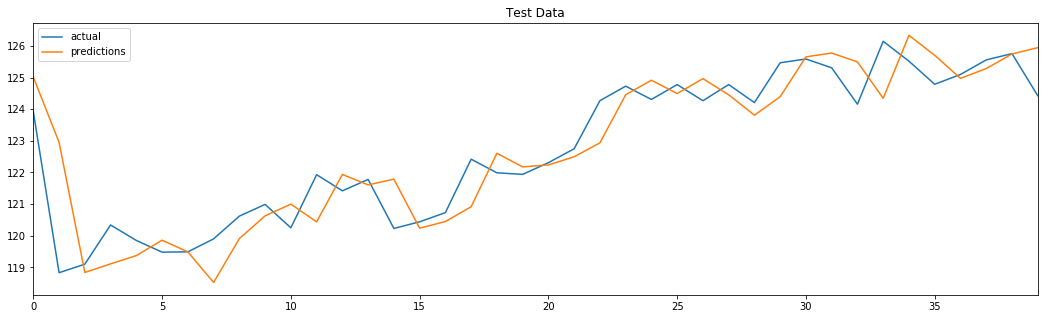

In [34]:
create_plot(list(df_pred.Open_pred.values), list(df_pred.Open_Act.values), title="Test Data")